**15장 – RNN과 CNN을 사용해 시퀀스 처리하기**

_이 노트북은 15장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 15.1 순환 뉴런과 순환 층

**RNN**: Recurrent neural networks (순환 신경망)  
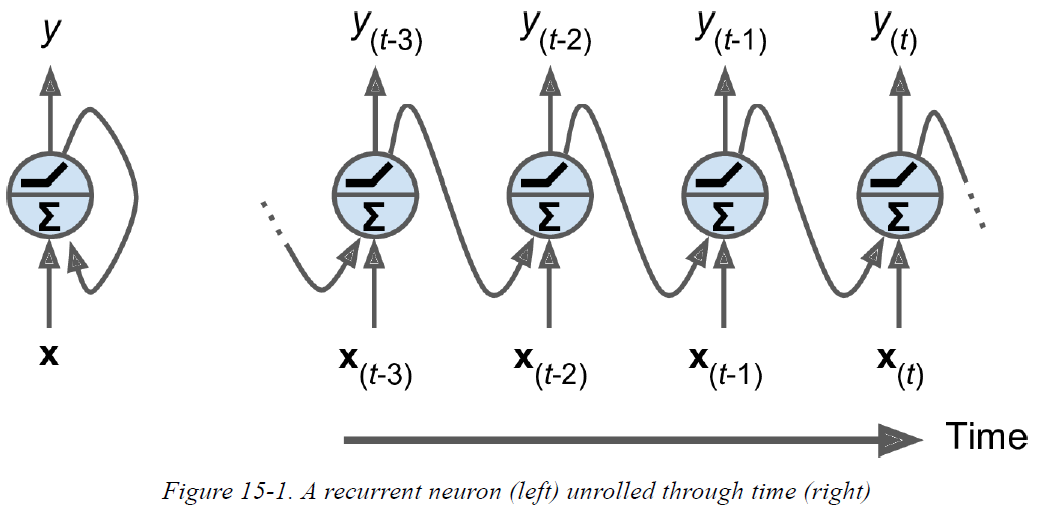
- 순환 뉴런(왼쪽)과 타임스텝으로 펼친 모습(오른쪽)  
  
  
- 각 **타임 스텝** t 마다 이 **순환 뉴련**은 물론 x(t)와 이전 타임 스텝의 출력인 y(t-1)을 입력으로 받는다.
- 첫 번째 타임 스텝에서는 이전 출력이 없으므로 일반적으로 0으로 설정한다.
- 이 작은 네트워크를 오른쪽 그림처럼 시간을 축으로 표현하면 **시간에 따라 네트워크를 펼쳤다**고 말한다.  
  
  
- 밑에 그림처럼 타임 스텝 t마다 모든 뉴런은 입력 벡터 x(t)와 이전 타임 스텝의 출력 벡터 y(t-1)을 받는다.
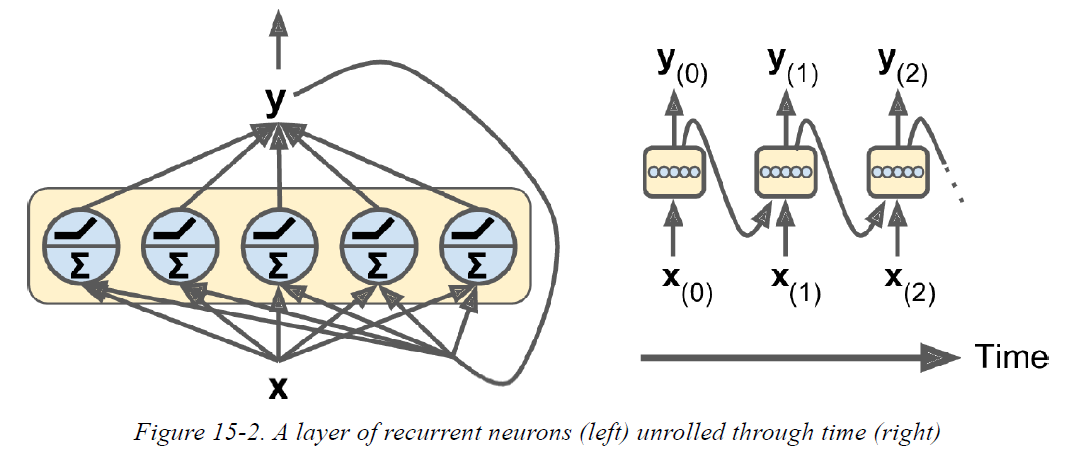  

- 각 순환 뉴런은 입력을 위한 가중치 행렬 Wx와 출력을 위한 가중치 행렬 Wy를 갖는다.
- 순환 층의 출력에 대한 계산식은 다음과 같다.
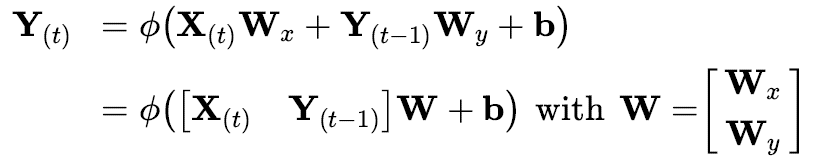  
- 결국 Y(t)는 시간 t=0에서부터 모든 입력에 대한 함수가 된다.

## 15.1.1 메모리 셀

- 타임 스텝 t에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이므로 이를 일종의 **메모리** 형태라고 말할 수 있다.
- 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 **메모리 셀**(혹은 간단히 **셀**)이라고 한다.  
  
  
- 일반적으로 타임 스텝 t에서의 셀의 상태 h(t) (h는 히든(hidden)을 의미)는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수이다. 즉, h(t) = f(h(t-1), x(t))이다.
- 타임 스텝 t에서의 출력 y(t)도 이전 상태와 현재 입력에 대한 함수이다.
- **셀의 히든 상태와 출력은 다를 수 있다.**
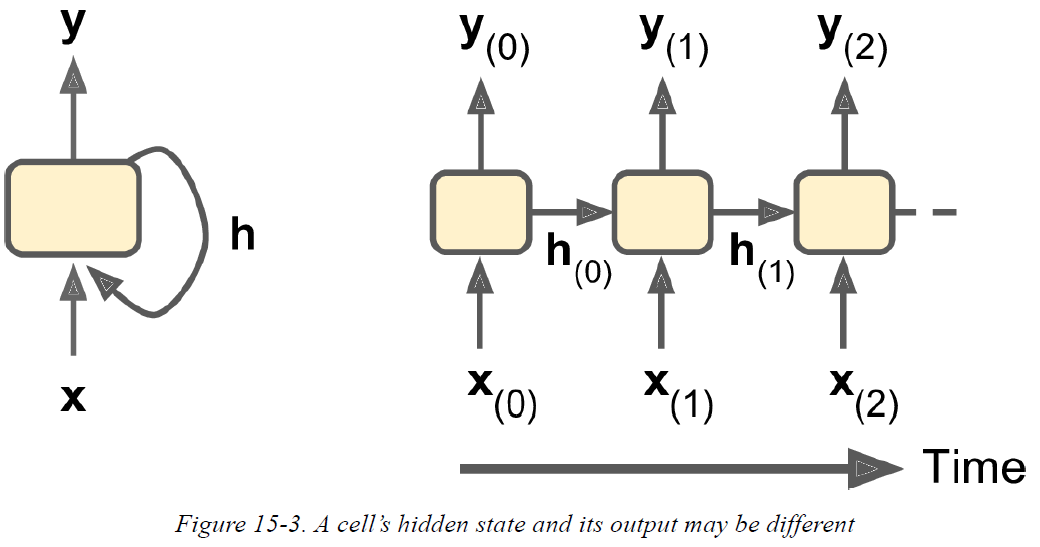

## 15.1.2 입력과 출력 시퀀스

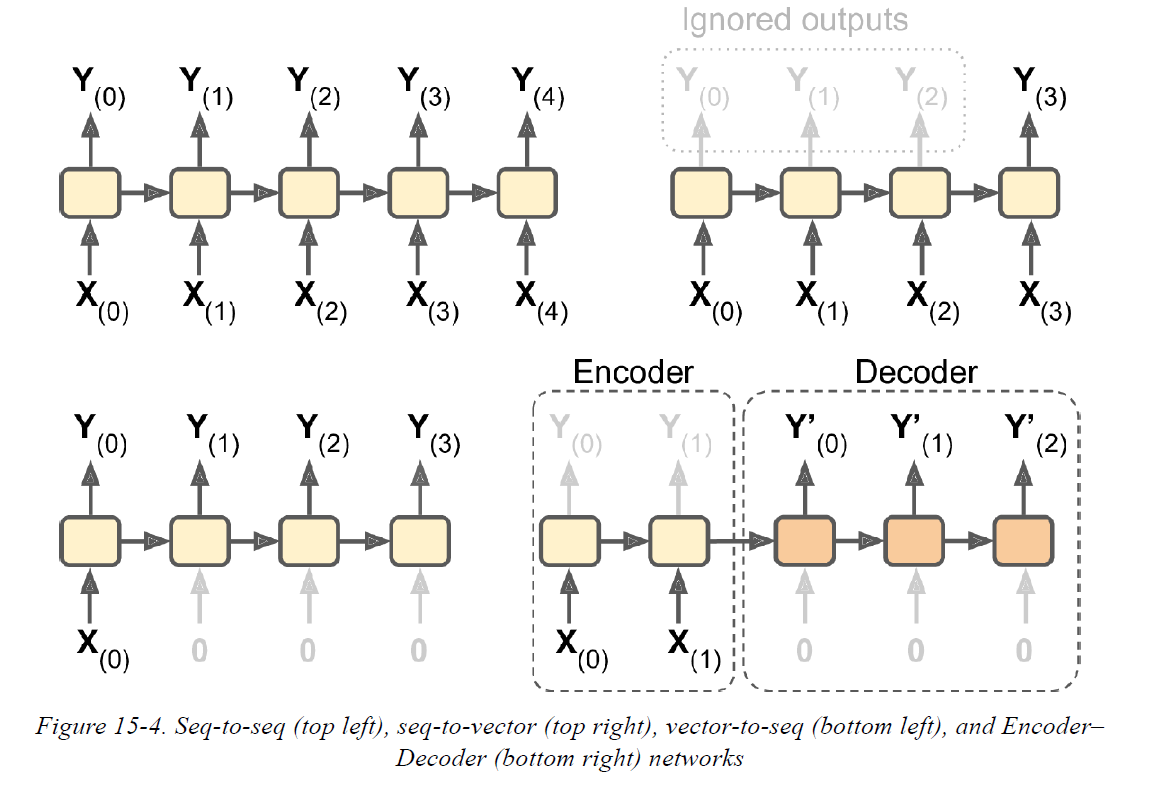  
  
(왼쪽 위부터 좌에서 우로)

- (1) **sequence-to-sequence network**
    - ex: 주식가격 같은 시계열 데이터를 예측
- (2) **sequence-to-vector network**
    - ex: 영화 리뷰에 있는 연속된 단어를 주입하고 감성 점수를 출력
- (3) **vector-to-sequence network**
    - ex: 이미지를 입력하여 이미지에 대한 캡션 출력
- (4) **encoder-decoder**
    - ex: 한 언어의 문장을 다른 언어로 번역

# 15.3 시계열 예측하기

#### 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


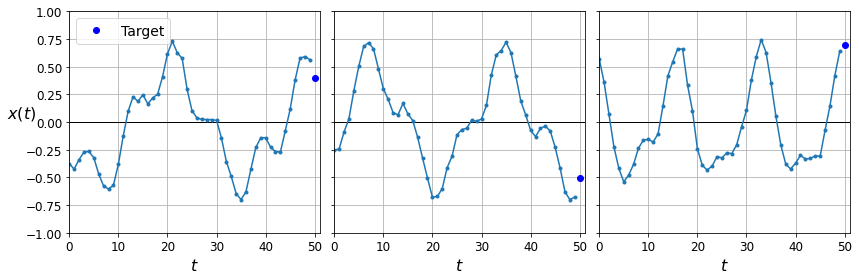

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타냅니다. 처음에 책에서 파란 X 표시를 타깃에 사용하고 빨강 점을 예측에 사용했다가 나중에 바꾸었습니다. 혼동을 드려 죄송합니다.

## 15.3.1 기준 성능

단순한 예측 (마지막 관측값을 사용해 예측합니다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

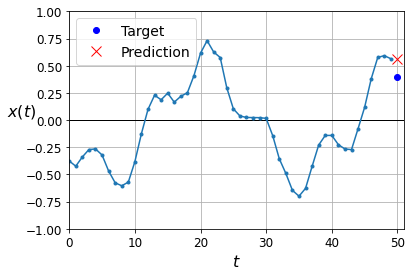

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

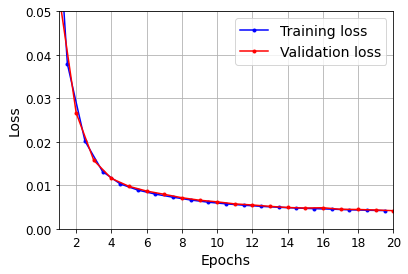

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 4ms/step


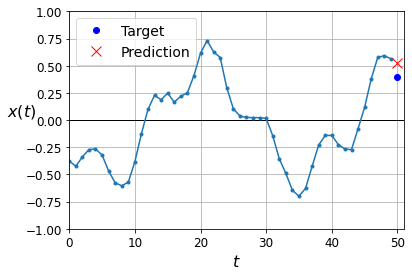

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.2 간단한 RNN 구현하기

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 8s 33ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0116 - val_lo

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0109


0.010881561785936356

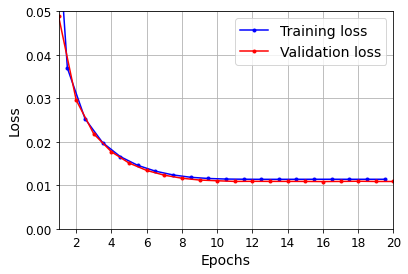

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


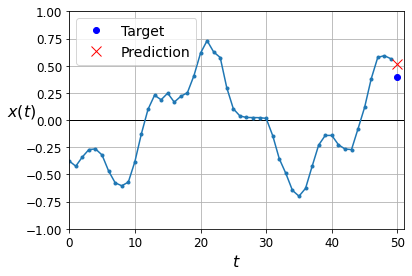

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.3 심층 RNN

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 29s 125ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 35s 160ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 27s 125ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 26s 121ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 28s 128ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0029


0.0029105597641319036

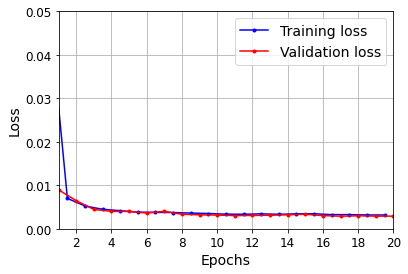

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 13ms/step


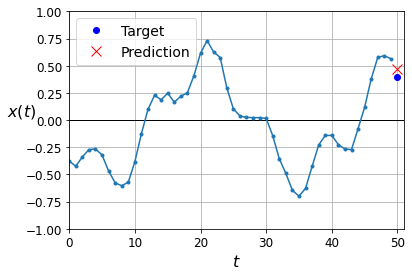

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환합니다:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 21s 89ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 19s 88ms/step - loss: 0.003

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0026


0.0026236248668283224

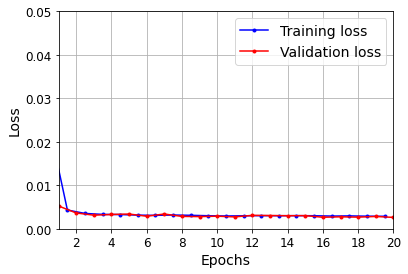

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 9ms/step


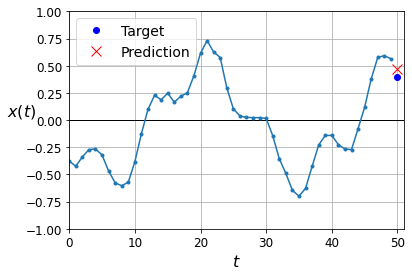

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.4 여러 타임 스텝 앞을 예측하기

In [24]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 25ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


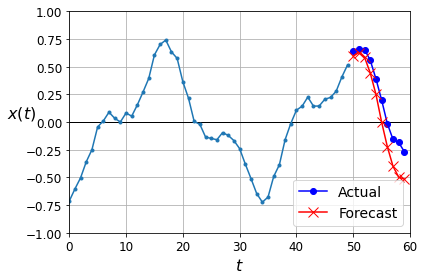

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 보겠습니다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 합니다.

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

이제 하나씩 다음 10개의 값을 예측합니다:

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 11ms/step


In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510844

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 보죠:

In [31]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0222

이제 동시에 다음 10개의 값을 모두 예측하는 RNN을 만들어 보겠습니다:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 21s 89ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 18s 83ms/step - loss: 0.011

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 209ms/step


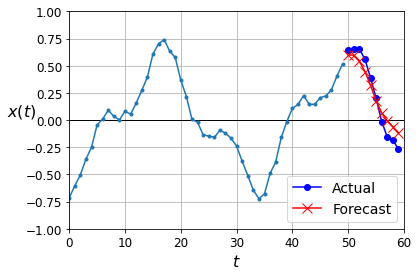

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 보겠습니다. 즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측합니다. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측합니다. 이 모델은 인과 모델입니다. 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있습니다.

In [36]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 20s 87ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0323 - last_time_step_mse: 0.0211 - val_loss: 0.0296 - val_last_time_step_mse: 0.0178
Epoch 4/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0296 - last_time_step_mse: 0.0183 - val_loss: 0.0277 - val_last_time_step_mse: 0.0156
Epoch 5/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0273 - last_time_step_mse: 0.0155 - val_loss: 0.0297 - val_last_time_step_mse: 0.0228
Epoch 6/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0250 - last_time_step_mse: 0.0124 - val_loss: 0.0249 - val_last_time_step_mse: 0.0119
Epoch 7/20
219/2

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 238ms/step


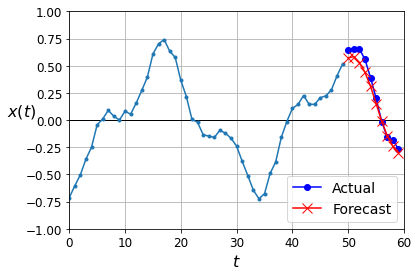

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 15.4 긴 시퀀스 다루기

## 15.4.1 불안정한 그레이디언트 문제와 싸우기

#### 배치 정규화를 사용한 심층 RNN

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 21s 87ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/2

#### 층 정규화를 사용한 심층 RNN

In [41]:
from tensorflow.keras.layers import LayerNormalization

In [42]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 51s 211ms/step - loss: 0.1590 - last_time_step_mse: 0.1548 - val_loss: 0.0734 - val_last_time_step_mse: 0.0668
Epoch 2/20
219/219 [==============================] - 40s 182ms/step - loss: 0.0647 - last_time_step_mse: 0.0548 - val_loss: 0.0575 - val_last_time_step_mse: 0.0440
Epoch 3/20
219/219 [==============================] - 42s 192ms/step - loss: 0.0532 - last_time_step_mse: 0.0405 - val_loss: 0.0491 - val_last_time_step_mse: 0.0371
Epoch 4/20
219/219 [==============================] - 40s 181ms/step - loss: 0.0470 - last_time_step_mse: 0.0353 - val_loss: 0.0441 - val_last_time_step_mse: 0.0324
Epoch 5/20
219/219 [==============================] - 41s 185ms/step - loss: 0.0426 - last_time_step_mse: 0.0312 - val_loss: 0.0404 - val_last_time_step_mse: 0.0280
Epoch 6/20
219/219 [==============================] - 50s 228ms/step - loss: 0.0388 - last_time_step_mse: 0.0268 - val_loss: 0.0365 - val_last_time_step_mse: 0.0241
Epoch 7/20

#### 사용자 정의 RNN 클래스 만들기

In [45]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 44s 192ms/step - loss: 0.1593 - last_time_step_mse: 0.1557 - val_loss: 0.0726 - val_last_time_step_mse: 0.0668
Epoch 2/20
219/219 [==============================] - 40s 185ms/step - loss: 0.0634 - last_time_step_mse: 0.0521 - val_loss: 0.0566 - val_last_time_step_mse: 0.0426
Epoch 3/20
219/219 [==============================] - 46s 208ms/step - loss: 0.0529 - last_time_step_mse: 0.0382 - val_loss: 0.0497 - val_last_time_step_mse: 0.0331
Epoch 4/20
219/219 [==============================] - 44s 202ms/step - loss: 0.0465 - last_time_step_mse: 0.0305 - val_loss: 0.0436 - val_last_time_step_mse: 0.0279
Epoch 5/20
219/219 [==============================] - 41s 185ms/step - loss: 0.0419 - last_time_step_mse: 0.0267 - val_loss: 0.0405 - val_last_time_step_mse: 0.0243
Epoch 6/20
219/219 [==============================] - 44s 200ms/step - loss: 0.0385 - last_time_step_mse: 0.0235 - val_loss: 0.0364 - val_last_time_step_mse: 0.0206
Epoch 7/20

## 15.4.2 단기 기억 문제 해결하기

### LSTM (long short-term memory) 셀

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 14ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788686841726303, 0.008560806512832642]

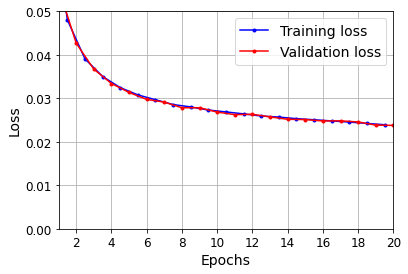

In [48]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [49]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 1s/step


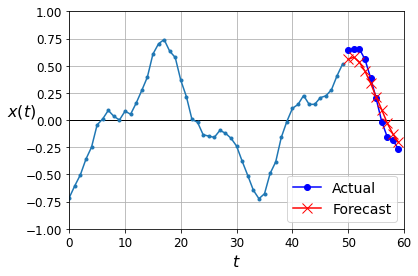

In [50]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRU 셀

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 12ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [======

In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785503581166267, 0.0102628068998456]

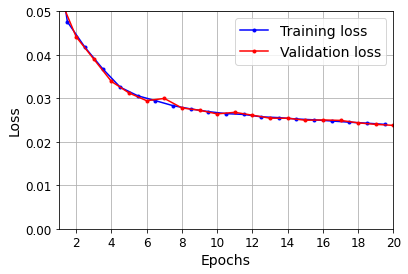

In [53]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [54]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 593ms/step


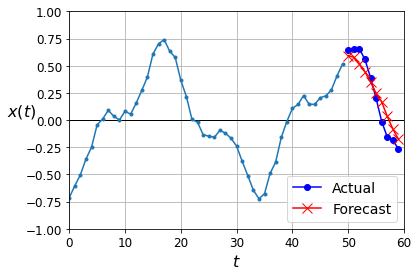

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 1D 합성곱 층을 사용해 시퀀스 처리하기

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 9s 10ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=======

### WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0323 - last_time_step_mse: 0.0192 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

다음은 논문에 정의된 원본 WaveNet입니다: ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용합니다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩합니다:

In [59]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [60]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 3s 9ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 2s 7ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


이 장에서 RNN의 기초 사항을 살펴 보았고 RNN을 사용해 시퀀스(소위 시계열)을 처리했습니다. CNN을 포함하여 시퀀스를 처리하는 다른 방법도 알아 보았습니다. 다음 장에서는 RNN을 자연어 처리에 적용해 보겠습니다. 그리고 RNN에 대해 더 자세히 배워 보겠습니다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션을 사용한 인코더-디코더). 또한 어텐션만 사용하는 구조인 트랜스포머도 살펴 보겠습니다.

# 연습문제 해답

## 1. to 8.

부록 A 참조.

## 9. SketchRNN 데이터셋 다루기

_연습문제: 텐서플로 데이터셋에서 제공하는 SketchRNN 데이터셋으로 분류 모델을 훈련해보세요._

이 데이터셋은 아직 TFDS에서 제공하지 않습니다. 아직 [풀 리퀘스트](https://github.com/tensorflow/datasets/pull/361)가 진행 중입니다. 다행히 이 데이터는 TFRecord로 제공되므로 다운로드해보죠(3,450,000 훈련 스케치와 345,000 테스트 스케치가 포함된 이 데이터셋은 1GB 정도되기 때문에 다운로드 시간이 조금 걸립니다):

In [ ]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [ ]:
train_files

['/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [ ]:
eval_files

['/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.07058823  0.04255319  0.        ]
  [-0.01568627  0.0425532   0.        ]
  [-0.09803921  0.03191489  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.07058824  0.27741933  0.        ]
  [-0.02745098  0.06451613  0.        ]
  [-0.02352941  0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.17857143  0.06666667  0.        ]
  [-0.26020408  0.15294117  0.        ]
  [-0.01020408  0.01568627  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.03056769 -0.01176471  0.        ]
  [ 0.29694325  0.          0.        ]
  [ 0.38864627  0.04705882  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

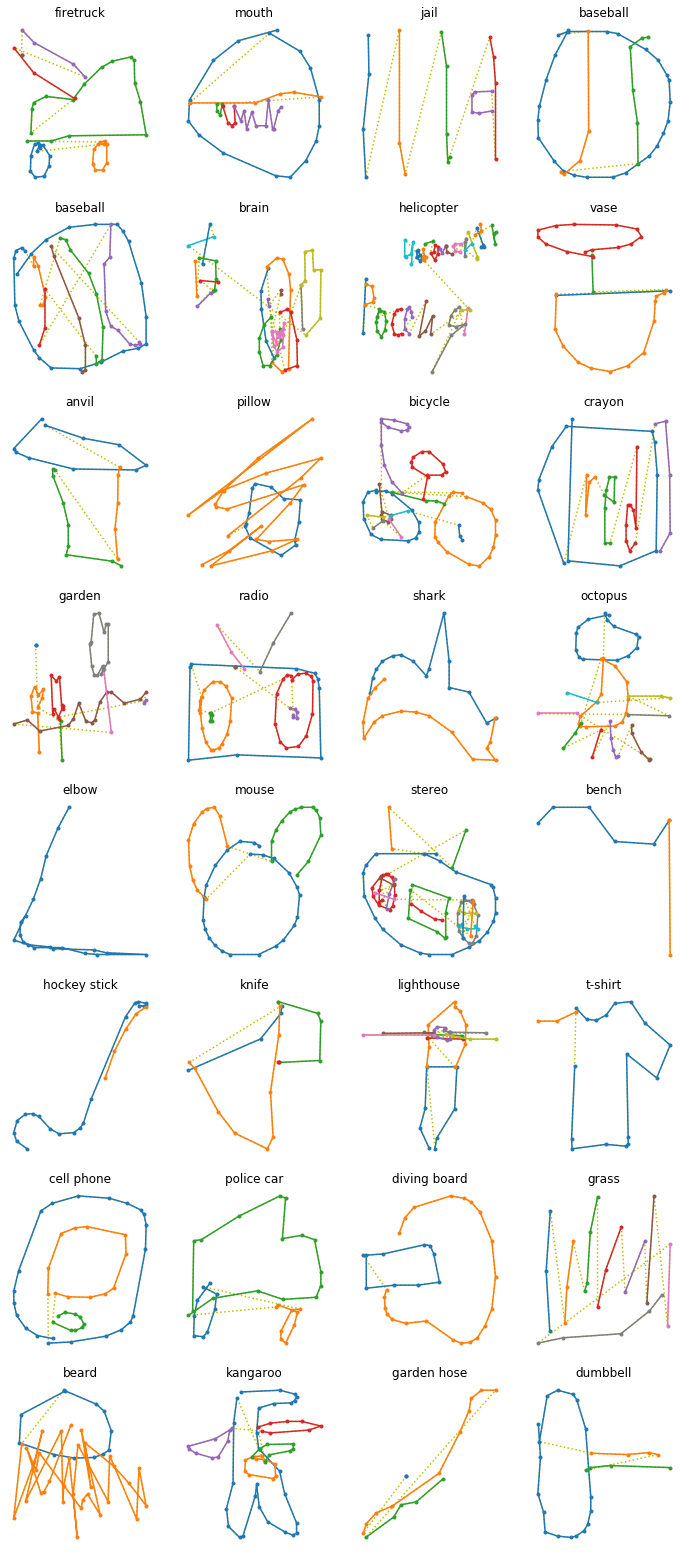

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

대부분의 스케치는 100개 포인트 이하로 구성되어 있습니다:

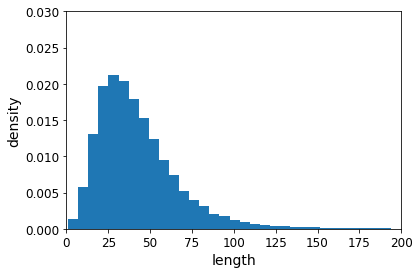

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2182s 20ms/step - loss: 3.8473 - accuracy: 0.2086 - sparse_top_k_categorical_accuracy: 0.4242 - val_loss: 2.6672 - val_accuracy: 0.3872 - val_sparse_top_k_categorical_accuracy: 0.6771
Epoch 2/2
107813/107813 [==============================] - 2049s 19ms/step - loss: 2.3393 - accuracy: 0.4502 - sparse_top_k_categorical_accuracy: 0.7367 - val_loss: 2.1072 - val_accuracy: 0.4968 - val_sparse_top_k_categorical_accuracy: 0.7759


In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6899671

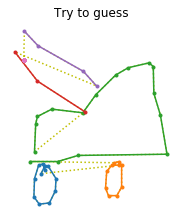

Top-5 predictions:
  1. firetruck 46.565%
  2. police car 30.455%
  3. ambulance 3.810%
  4. car 3.695%
  5. cannon 3.371%
Answer: firetruck


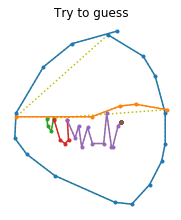

Top-5 predictions:
  1. mouth 23.162%
  2. pond 14.151%
  3. pool 12.582%
  4. beard 11.375%
  5. goatee 9.808%
Answer: mouth


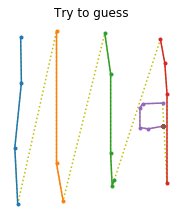

Top-5 predictions:
  1. jail 71.532%
  2. fence 6.519%
  3. swing set 5.708%
  4. grass 3.302%
  5. rain 3.023%
Answer: jail


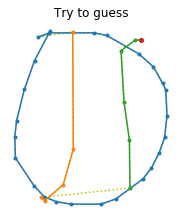

Top-5 predictions:
  1. baseball 79.233%
  2. watermelon 7.687%
  3. basketball 5.259%
  4. clock 1.659%
  5. compass 1.101%
Answer: baseball


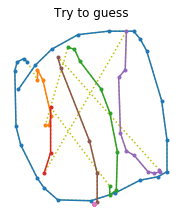

Top-5 predictions:
  1. basketball 51.888%
  2. baseball 17.328%
  3. onion 12.688%
  4. watermelon 9.989%
  5. brain 2.216%
Answer: baseball


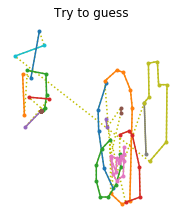

Top-5 predictions:
  1. lantern 7.235%
  2. toothpaste 6.845%
  3. drill 6.254%
  4. lighthouse 4.624%
  5. crayon 3.566%
Answer: brain


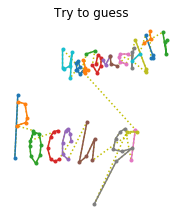

Top-5 predictions:
  1. animal migration 8.771%
  2. blackberry 7.932%
  3. blueberry 6.413%
  4. peas 5.549%
  5. bracelet 3.623%
Answer: helicopter


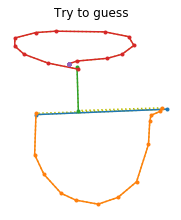

Top-5 predictions:
  1. vase 42.793%
  2. wine glass 13.744%
  3. shovel 8.136%
  4. house plant 5.144%
  5. sailboat 4.850%
Answer: vase


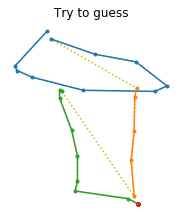

Top-5 predictions:
  1. anvil 25.870%
  2. drill 9.670%
  3. nail 7.246%
  4. screwdriver 5.611%
  5. knee 4.355%
Answer: anvil


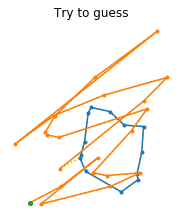

Top-5 predictions:
  1. hurricane 34.674%
  2. tornado 16.056%
  3. blackberry 7.664%
  4. squiggle 5.489%
  5. zigzag 4.906%
Answer: pillow


In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_sketchrnn/assets


## 10. 바흐 합창곡

_연습문제: [바흐 합창곡](https://homl.info/bach) 데이터셋을 다운로드하여 압축을 풉니다. 이 데이터셋은 요한 제바스티안 바흐가 작곡한 382개의 합창곡으로 구성되어 있습니다. 각 곡은 100에서 640까지 타임 스텝 길이입니다. 각 타임 스텝은 4개의 정수를 담고 있습니다. 각 정수는 피아노 음표의 인덱스에 해당합니다(연주되는 음표가 없다는 것을 의미하는 0은 제외). 코랄의 타임 스텝 시퀀스가 주어지면 다음 타임 스텝(4개의 음표)을 예측할 수 있는 순환 모델, 합성곱 모델 또는 두 가지를 합친 모델을 훈련하세요. 그 다음 이 모델을 사용해 한 번에 하나의 음표씩 바흐와 같은 음악을 생성하세요. 코랄의 시작 부분을 모델에 주입하고 다음 타임 스텝을 예측합니다. 이 타임 스텝을 입력 시퀀스에 추가하여 모델이 다음 음표를 예측하게 만드는 식입니다. 또 바흐를 위한 [구글 두들](https://www.google.com/doodles/celebrating-johann-sebastian-bach)에 사용한 구글의 [Coconet 모델](https://homl.info/coconet)을 확인해보세요._

In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

음표의 범위는 36(C1 = 옥타브 1의 C)에서 81(A5 = 옥타브 5의 A)까지이고 무음을 위해 0을 추가합니다:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

이 코랄을 듣기 위한 몇 개의 함수를 만들어 보죠(자세한 내용을 이해할 필요는 없습니다. 사실 MIDI 플레이어처럼 더 간단한 방법이 있지만 그냥 하나의 합성기(synthesizer)를 만들어 보고 싶었습니다):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # 한 옥타브 올라갈 때 주파수는 두배가 됩니다; 옥타브마다 12개의 반음이 있습니다;
    # 옥타브 4의 A는 440Hz이고 음표 번호는 69입니다.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # tempo는 분당 박자 수로 측정합니다
    # 매 박자마다 딸깍거리는 소리를 줄이기 위해 주파수를 반올림하여 각 음의 끝에서 샘플을 0에 가깝게 만듭니다.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # (음표 0 = 무음을 포함해) 9Hz 이하인 주파수는 모두 삭제합니다
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # 마지막 음표를 조금 더 길게합니다
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # 마지막 음을 희미하게 합니다
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

이제 몇 개의 코랄을 들어 보죠:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

멋지네요! :)

새로운 코랄을 생성하기 위해서는 이전의 화음이 주어졌을 때 다음 화음을 예측할 수 있는 모델을 훈련해야 합니다. 한 번에 4개의 음표를 예측하는 식으로 다음 화음을 예측한다면 잘 어울리지 않는 음표를 얻게 됩니다(믿으세요. 제가 해 보았습니다). 한 번에 하나의 음표를 예측하는 것이 간단하고 더 낫습니다. 따라서 모든 코랄을 전처리하여 각 화음을 아르페지오로 바꾸어야 합니다(즉, 동시에 연주되는 음표가 아니라 음표의 시퀀스). 그다음 이전의 모든 음표가 주어졌을 때 다음 음표를 예측하는 모델을 훈련할 수 있습니다. 시퀀스-투-시퀀스 방식을 사용하겠습니다. 신경망에 한 윈도를 주입하고 한 타임 스텝 미래로 이동한 윈도를 예측합니다.

또한 0에서 46까지 범위를 갖도록 값을 이동시키겠습니다. 여기에서 0은 무음을 나타내고 1에서 46까지는 36(C1)에서 81(A5)까지를 나타냅니다.

128 음표(즉, 32개 화음)의 윈도에서 모델을 훈련하겠습니다.

이 데이터셋은 메모리에 올라갈 수 있기 때문에 파이썬 코드를 사용해 RAM에서 코랄을 전처리할 수 있지만 여기에서는 tf.data를 사용해 전처리하는 방법을 시연하겠습니다(다음 장에서 tf.data를 사용해 윈도를 만드는 과정을 자세히 설명하겠습니다).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # 각 스텝에서 아르페지오에 있는 다음 음표를 예측합니다
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # 값 이동
    return tf.reshape(window, [-1]) # 아르페지오로 변환

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

훈련 세트, 검증 세트, 테스트 세트를 만듭니다:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

이제 모델을 만듭니다:

* 음표를 실수 값으로 모델에 직접 주입할 수 있지만 좋은 결과를 얻지 못할 것입니다. 음표 간의 관계는 단순하지 않습니다. 예를 들어 C3을 C4로 바꾼다면 두 음표 사이에 반음이 12개(즉 한 옥타브) 떨어져 있음에도 멜로디는 여전히 괜찮게 들립니다. 반대로 C3을 C\#3으로 바꾼다면 바로 다음 음표임에도 화음이 매우 좋지 않습니다. 따라서 `Embedding` 층을 사용해 음표를 작은 벡터 표현으로 바꾸겠습니다(임베딩에 대해서는 16장을 참고하세요). 5-차원 임베딩을 사용하므로 첫 번째 층의 출력은 `[batch_size, window_size, 5]` 크기가 됩니다.
* 그 다음 이 데이터를 4개의 `Conv1D` 층을 쌓고 dilation 비율을 두 배씩 늘린 작은 WeveNet 신경망에 주입합니다. 빠른 수렴을 위해 이 층 다음에 `BatchNormalization` 층을 배치합니다.
* 그다음 하나의 `LSTM` 층이 장기 패턴을 감지합니다.
* 마지막으로 `Dense` 층이 최종 음표 확률을 생성합니다. 타임 스텝과 (무음을 포함해) 가능한 음표 마다 배치에 있는 각 코랄에 대해 하나의 확률을 예측합니다. 따라서 출력 크기는 `[batch_size, window_size, 47]`가 됩니다.

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           235       
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          2

이제 모델을 컴파일하고 훈련할 준비가 되었습니다!

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 17s 171ms/step - loss: 1.8198 - accuracy: 0.5358 - val_loss: 3.7675 - val_accuracy: 0.0428
Epoch 2/20
98/98 [==============================] - 15s 152ms/step - loss: 0.8885 - accuracy: 0.7641 - val_loss: 4.1054 - val_accuracy: 0.0470
Epoch 3/20
98/98 [==============================] - 16s 165ms/step - loss: 0.7471 - accuracy: 0.7930 - val_loss: 3.8600 - val_accuracy: 0.0368
Epoch 4/20
98/98 [==============================] - 16s 165ms/step - loss: 0.6749 - accuracy: 0.8083 - val_loss: 3.0490 - val_accuracy: 0.2196
Epoch 5/20
98/98 [==============================] - 15s 157ms/step - loss: 0.6221 - accuracy: 0.8188 - val_loss: 1.7138 - val_accuracy: 0.5153
Epoch 6/20
98/98 [==============================] - 16s 163ms/step - loss: 0.5833 - accuracy: 0.8283 - val_loss: 1.9068 - val_accuracy: 0.4570
Epoch 7/20
98/98 [==============================] - 16s 165ms/step - loss: 0.5484 - accuracy: 0.8362 - val_loss: 0.7930 - val_accuracy: 0.7678

여기서는 하이퍼파라미터 탐색을 많이 수행하지 않았습니다. 자유롭게 이 모델을 사용해 하이퍼파라미터를 탐색하고 최적화해 보세요. 예를 들어 `LSTM` 층을 제거하고 `Conv1D` 층으로 바꿀 수 있습니다. 층의 개수, 학습률, 옵티마이저 등을 실험해 볼 수 있습니다.

검증 세트에 대한 모델의 성능이 만족스럽다면 모델을 저장하고 테스트 세트에서 마지막으로 평가합니다:

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

     34/Unknown - 2s 66ms/step - loss: 0.6557 - accuracy: 0.8164

[0.6556663916391485, 0.8164004]

**노트:** 이 예제에서는 테스트 세트가 진짜로 필요하지 않습니다. 모델이 생성한 음악을 듣는 것이 최종 평가가 되기 때문입니다. 따라서 필요하다면 테스트 세트를 훈련 세트에 넣고 모델을 다시 훈련하여 조금 더 나은 모델을 얻을 수 있습니다.

이제 새로운 코럴을 생성하는 함수를 만들어 보죠. 몇 개의 시드 화음을 주고 이를 (모델이 기대하는 포맷인) 아르페지오로 변환합니다. 그다음 모델을 사용해 다음 음표을 예측합니다. 마지막에 4개씩 음표를 모아서 다시 화음을 만들고 최종 코럴을 반환합니다.

**경고**: `model.predict_classes(X)`는 deprecated 되었습니다. 대신 `np.argmax(model.predict(X), axis=-1)`을 사용하세요.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수를 테스트하려면 시드 화음이 필요합니다. 테스트 코럴 중 하나에 있는 처음 8개의 화음을 사용해 보죠(실제로 이는 4번 반복되는 2개의 화음입니다):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

첫 번째 코럴을 생성할 준비를 마쳤습니다! 56개의 화음을 생성하여 총 64개의 화음, 즉 4 소절(소절마다 4개의 화음인 4/4박으로 가정합니다)을 만들어 보겠습니다:

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

이 방식에는 한가지 단점이 있습니다: 너무 보수적인 경우가 많습니다. 실제로 이 모델은 모험을 하지 않아 항상 가장 높은 확률의 음표를 선택합니다. 이전 음표를 반복하면 충분히 듣기 좋고 가장 덜 위험하기 때문에 이 알고리즘은 마지막 음표를 오래 지속시키는 경향이 있습니다. 상당히 지루합니다. 또한 이 모델을 여러 번 실행하면 항상 같은 멜로디를 생성할 것입니다.

조금 더 신나게 만들어 보죠! 항상 가장 높은 점수의 음표를 선택하는 대신, 예측된 확률을 기반으로 랜덤하게 다음 음표를 선택하겠습니다. 예를 들어, 모델이 75% 확률로 C3를 예측하고 25% 확률로 G3를 예측했다면 이 확률대로 랜덤하게 두 음표 중 하나를 선택하겠습니다. 또한 `temperature` 매개변수를 추가하여 시스템의 온도(즉 대담성)를 제어하겠습니다. 높은 온도는 예측 확률을 비슷하게 만들어 가능성이 높은 음표의 확률을 줄이고 가능성이 낮은 음표의 확률을 높입니다.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수로 3개의 코랄을 생성해 보겠습니다. 하나는 차갑게, 하나는 중간으로, 하나는 뜨겁게 만듭니다(시드, 길이, 온도를 사용해 자유롭게 실험해 보세요). 다음 코드는 각 코랄을 별개의 파일에 저장합니다. 마음에 드는 음악을 만날 때까지 이 셀을 반복해서 실행할 수 있습니다!

**가장 아름다운 코럴을 트위터 @aureliengeron로 공유해 주시면 정말 감사하겠습니다! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

마지막으로 재미있는 실험을 해 볼 수 있습니다: 친구에게 마음에 드는 코럴 몇 개와 진짜 코럴을 보내고 어떤 것이 진짜인지 물어 보세요!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")